### create data from stock

In [2]:
pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ----------------- ---------------------- 1.3/3.0 MB 6.1 MB/s eta 0:00:01
     ------------------------------- -------- 2.4/3.0 MB 5.8 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 5.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   -------------------------------------- - 1.3/1.4 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 6.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.18.1-py3-none-any.whl size=139099 sha256=505384b43af03d2c04e481e34164044efbc3f9890db06df406a1e0492

In [4]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 6.1 MB/s eta 0:00:02
   ------------- -------------------------- 2.6/8.1 MB 6.3 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.1 MB 6.3 MB/s eta 0:00:01
   -------------------------- ------------- 5.2/8.1 MB 6.4 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------  7.9/8.1 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 6.2 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ----------------------- ---------------- 1.3/2.2 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 6.0 MB/s eta 0:0

In [74]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from curl_cffi import requests

SYMBOL = "IFX.DE"
HISTORY = "10y"

class stock_datasets:
    CLASSES = ["Bull", "Bear"]
    def __init__(self, stock=None, period=None, interval="1d", win_size=60):
        self._stock = stock if stock is not None else None
        self._period = period if period is not None else None
        self._interval = interval if interval is not None else None
        ### default all features
        self._base_features = ['Open', 'High', 'Low', 'Close', 'Volume', "Dividends", "Stock Splits"]
        self._stock_data = None
        self._X_train = None
        self._Y_train = None
        self._X_test = None
        self._Y_test = None
        self._window_size = win_size # default 60 days

    @property
    def stock_data(self):
        return self._stock_data

    @property
    def test_data(self):
        if self._data is None:
            return None
        return self._data

    @property
    def test_data_num(self):
        if self._data is None:
            return 0
        return len(self._data)
        
    @property
    def features(self):
        if self._features is None:
            return self._base_features
        return self._features

    @property
    def window_size(self):
        return self._window_size

    @window_size.setter
    def window_size(self, ws):
        self._window_size = ws
        
    def load_stock(self, stock=None, period=None, interval=None):
        ## read stock data from stock markt
        self._stock = stock if stock is not None else self._stock
        self._period = period if period is not None else self._period
        self._interval = interval if interval is not None else self._interval    
        self.session = requests.Session(impersonate="chrome")
        self._stock_data = yf.Ticker(self._stock, session=self.session).history(period=self._period, interval=self._interval)
        self._features = None
        self._data = self._stock_data ## used for prediction process
        
    def set_working_data(self, features=(0, 5), remove_cols=["Dividends", "Stock Splits"]):
        self._features = [self._base_features[f] for f in range(features[0],features[1])]
        ### remove meaningless columns
        self._data = self._stock_data.drop(columns=remove_cols)
        # remove today data
        self._data = self._data[:-1]
        self._normalize_data()
    
    def _normalize_data(self):
        scaler = MinMaxScaler(feature_range=(0, 1))
        self._data = scaler.fit_transform(self._data)

    def _create_sequences(self):
        if self.test_data_num < self._window_size:
            raise ValueError("Too few number of data")
        X, Y = [], []
        for i in range(self.test_data_num - self._window_size):
            # Input: add all features: Open, High, Low, Close, Volume
            X.append(self._data[i:i+self._window_size, :]) 
            # Output: predict Close price
            Y.append(self._data[i+self._window_size, 3]) 
        return np.array(X), np.array(Y)

    def create_train_test_data(self, train_data_percentage=0.7):
        if self.test_data_num < self._window_size:
            raise ValueError("Too few number of data")
        if train_data_percentage >= 1.0:
            raise ValueError("Percent must less than 1.0")
        X, Y = self._create_sequences()
        split = int(train_data_percentage * len(X))
        self._X_train, self._X_test = X[:split], X[split:]
        self._Y_train, self._Y_test = Y[:split], Y[split:]

    def create_LSTM_model(self):
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(self.window_size, self._features.shape[2])),  # 输入维度为 (窗口大小, 特征数)
            Dropout(0.3),
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            Dense(1)
        ])


In [75]:
stock_daten = stock_datasets(SYMBOL, HISTORY)
stock_daten.load_stock()

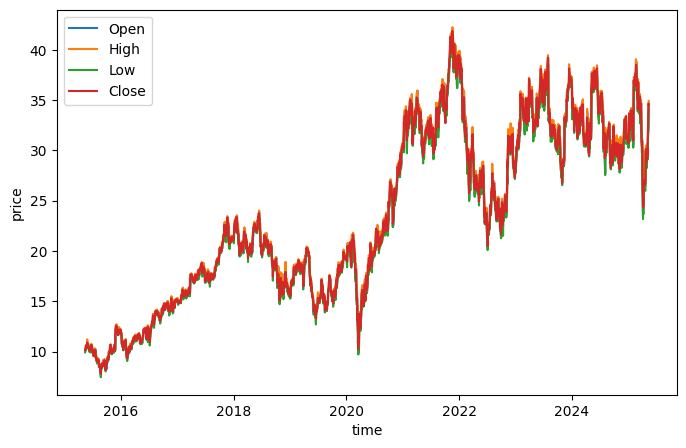

In [68]:
%matplotlib inline
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(8, 5))
plt.plot(stock_daten.test_data[stock_daten.features[0]], label=stock_daten.features[0])
plt.plot(stock_daten.test_data[stock_daten.features[1]], label=stock_daten.features[1])
plt.plot(stock_daten.test_data[stock_daten.features[2]], label=stock_daten.features[2])
plt.plot(stock_daten.test_data[stock_daten.features[3]], label=stock_daten.features[3])
#plt.xlim('2023.01.01', '2023.12.31')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [76]:
stock_daten.set_working_data()

AttributeError: 'stock_datasets' object has no attribute '_stock_datasets__data'

### check loaded data

In [70]:
print(stock_daten.test_data)
print(stock_daten.test_data.shape)

[[0.06437534 0.0656416  0.07292041 ... 0.094798   0.         0.        ]
 [0.07050014 0.06955041 0.07910233 ... 0.1182765  0.         0.        ]
 [0.07193355 0.07085328 0.07778699 ... 0.08766944 0.         0.        ]
 ...
 [0.687786   0.6970362  0.69650651 ... 0.09870626 0.         0.        ]
 [0.71167377 0.76781368 0.72796793 ... 0.19533636 0.         0.        ]
 [0.77343223 0.7788818  0.7772182  ... 0.1133851  0.         0.        ]]
(2542, 7)


#### construct datasets

In [55]:
print(stock_daten.features)

['Open', 'High', 'Low', 'Close', 'Volume']


In [56]:
stock_daten.create_train_test_data()

In [61]:
stock_daten._X_train.shape, stock_daten._Y_train.shape

((1737, 60, 7), (1737,))